In [1]:
!nvidia-smi
%matplotlib inline

Tue Jun 24 18:27:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.57.01              Driver Version: 565.57.01      CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  |   00000000:CA:00.0 Off |                    0 |
| N/A   47C    P0            254W /  400W |   39282MiB /  40960MiB |     95%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [1]:
import pandas as pd
import json
import re
import numpy as np
from typing import List, Optional, Dict, Any
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm import tqdm
import torch

%matplotlib inline

In [2]:
def obtain_results_without(input_csv, filter_set):
    result_df = pd.read_csv(input_csv)
    result_df = result_df[result_df['direct_source']!=filter_set]
    print(classification_report(result_df["gold_judgment"], result_df['model_pred']))
    
    judgment_gold = result_df['gold_judgment'].tolist()
    judgment_model = result_df["model_pred"].tolist()
    binary_labels = ['underspecified', 'fully specified']

    cm = confusion_matrix(judgment_gold, judgment_model, labels=binary_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=binary_labels)

    disp.plot(cmap='Blues')  # 可以调整 colormap

## Loading files

In [3]:
# For Snellius
input_csv = "../data/few_shots.csv"
df_few_shots = pd.read_csv(input_csv)
real_csv = "../data/Test_1155.csv"
df_test_1155 = pd.read_csv(real_csv)
learning_csv = "../data/in-context_learning_set.csv"
df_in_context_learning = pd.read_csv(learning_csv)

In [2]:
# For Colab
from google.colab import drive
drive.mount('/content/drive')

test_1155 = "/content/drive/My Drive/Engineering_files/Test_1155.csv"
df_test_1155 = pd.read_csv(test_1155)
few_shots = "/content/drive/My Drive/Engineering_files/few_shots.csv"
df_few_shots = pd.read_csv(few_shots)
in_context_learning = "/content/drive/My Drive/Engineering_files/in-context_learning_set.csv"
df_in_context_learning = pd.read_csv(in_context_learning)
in_context_learning_A = "/content/drive/My Drive/Engineering_files/learning_version_A.csv"
df_in_context_learning_A = pd.read_csv(in_context_learning_A)
in_context_learning_B = "/content/drive/My Drive/Engineering_files/learning_version_B.csv"
df_in_context_learning_B = pd.read_csv(in_context_learning_B)

Mounted at /content/drive


## Loading the model

In [4]:
Qwen3_4B = "Qwen/Qwen3-4B"

import os
os.environ['TRANSFORMERS_CACHE'] = '/scratch-local/yhuang/huggingface_cache'
# 确保目录存在
os.makedirs('/scratch-local/yhuang/huggingface_cache', exist_ok=True)

In [5]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained(Qwen3_4B, padding_side='left')
model = AutoModelForCausalLM.from_pretrained(Qwen3_4B)

# 将模型移到可用设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

/home/yhuang/sglang-venv-2/lib/python3.11/site-packages/transformers/utils/hub.py:105: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/9.73k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/32.8k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/3.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/99.6M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

cuda


## Helper functions

In [5]:
system_prompt = """
You are an expert analyst. Your task is to analyze and determine whether an input user query is "fully specified" or "underspecified".

"""

In [6]:
def batch_generate_responses_qwen3(prompts, system_prompt=system_prompt,
                             temperature=0.7, max_new_tokens=32768, batch_size=4,
                             enable_thinking=True, parse_thinking=True):
    """
    批量生成Qwen 3模型的回复

    参数:
        prompts: 字符串列表，每个字符串是一个提示词
        system_prompt: 系统提示词
        max_new_tokens: 生成的最大token数，默认为512
        batch_size: 每批处理的提示词数量，默认为4
        enable_thinking: 是否启用思考模式，默认为True
        parse_thinking: 是否解析思考内容，默认为True

    返回:
        如果parse_thinking=True，返回(思考内容列表, 回复内容列表)的元组
        如果parse_thinking=False，返回回复列表
    """

    responses = []
    thinking_contents = [] if parse_thinking else None

    # 按批次处理
    for i in tqdm(range(0, len(prompts), batch_size)):
        batch_prompts = prompts[i:i+batch_size]
        batch_texts = []

        # 为每个提示词准备输入文本
        for prompt in batch_prompts:
            if system_prompt:
                messages = [
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": prompt}
                ]
            else:
                messages = [
                    {"role": "user", "content": prompt}
                ]

            text = tokenizer.apply_chat_template(
                messages,
                tokenize=False,
                add_generation_prompt=True,
                enable_thinking=enable_thinking  # 启用思考模式
            )
            batch_texts.append(text)

        # 批量编码输入
        model_inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True).to(model.device)

        # 生成回复
        with torch.no_grad():
            generated_ids = model.generate(
                **model_inputs,
                max_new_tokens=max_new_tokens,
                do_sample=True,
                temperature=temperature,
                top_p=0.9,
                repetition_penalty=1.2
            )

        # 处理生成的回复
        batch_responses = []
        batch_thinking = [] if parse_thinking else None

        for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids):
            response_ids = output_ids[len(input_ids):].tolist()

            if parse_thinking and enable_thinking:
                # 解析思考内容
                try:
                    # 寻找</think>对应的token ID (151668)
                    index = len(response_ids) - response_ids[::-1].index(151668)
                except ValueError:
                    index = 0

                thinking_content = tokenizer.decode(response_ids[:index], skip_special_tokens=True).strip("\n")
                content = tokenizer.decode(response_ids[index:], skip_special_tokens=True).strip("\n")

                batch_thinking.append(thinking_content)
                batch_responses.append(content)
            else:
                # 不解析思考内容，直接返回完整回复
                response = tokenizer.decode(response_ids, skip_special_tokens=True)
                batch_responses.append(response)

        responses.extend(batch_responses)
        if parse_thinking:
            thinking_contents.extend(batch_thinking)

    if parse_thinking:
        return thinking_contents, responses
    else:
        return responses

def get_judgments_from_responses(responses: List[str]) -> List[Optional[str]]:
    """
    推荐的解析函数，结合了多种方法的优点
    """
    judgments = []

    for i, response in enumerate(responses):
        judgment = None

        try:
            # 方法1: 尝试直接解析JSON
            clean_response = response.strip()
            if clean_response.startswith('{') and clean_response.endswith('}'):
                data = json.loads(clean_response)
                judgment = data.get('judgment')
            else:
                # 方法2: 寻找JSON部分
                start_idx = clean_response.find('{')
                end_idx = clean_response.rfind('}')
                if start_idx != -1 and end_idx != -1:
                    json_part = clean_response[start_idx:end_idx+1]
                    data = json.loads(json_part)
                    judgment = data.get('judgment')

        except json.JSONDecodeError:
            # 方法3: 使用正则表达式作为后备
            pattern = r'"judgment"\s*:\s*"([^"]*)"'
            match = re.search(pattern, response)
            if match:
                judgment = match.group(1)

        if judgment is None:
            print(f"Warning: response {i} cannot retrieve judgment")
            print(f"Respond content: {response[:200]}...")
            judgment = "error"

        judgments.append(judgment)

    return judgments



def run_experiment(input_prompts, test_df):
  output = batch_generate_responses_qwen3(input_prompts)
  df = test_df.copy()
  df['thinking'] = output[0]
  df['model_response'] = output[1]
  to_process = output[1]
  processed_judgments = get_judgments_from_responses(to_process)
  df['model_pred'] = processed_judgments

  return df

def retrieve_results(result_df, output_name):
  processed_judgments = result_df['model_pred'].tolist()

  if "error" in processed_judgments:
    print("There are unrecognized labels.")
    result_df.to_csv(f'{output_name}_error.csv')
  else:
    print("No error found, directly process the data.")
    print(classification_report(result_df["gold_judgment"], result_df['model_pred']))
    result_df.to_csv(f'{output_name}.csv')

    judgment_gold = result_df['gold_judgment'].tolist()
    judgment_model = result_df["model_pred"].tolist()

    binary_labels = ['underspecified', 'fully specified']

    cm = confusion_matrix(judgment_gold, judgment_model, labels=binary_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=binary_labels)

    disp.plot(cmap='Blues')  # 可以调整 colormap

In [7]:
def prepare_test_prompts(test_df, task_text, learning_df=None, instruction_text=None, theory=False):
  print("Start preparing prompts...")
  if learning_df is not None and instruction_text is not None:
    print(f"# learning samples: {len(learning_df)}")
    examples = []
    if theory:
      for _, row in learning_df.iterrows():
        example = {
                "query": row['request'],
                "reasoning": row['reasoning'],
                "category": row['category'],
                "judgment": row['gold_judgment']
              }
        examples.append(json.dumps(example, ensure_ascii=False))

      examples_text = '\n\n'.join(examples)
      base_prompt = instruction_text + examples_text + task_text
    else:
      for _, row in learning_df.iterrows():
        example = {
                "query": row['request'],
                "judgment": row['gold_judgment']
              }
        examples.append(json.dumps(example, ensure_ascii=False))

      examples_text = '\n\n'.join(examples)
      base_prompt = instruction_text + examples_text + task_text

  else:
    base_prompt = task_text

  print(f"# Testing data points: {len(test_df)}")
  test_prompts = []
  for _, row in test_df.iterrows():
    query = row['request']
    complete_prompt = base_prompt.replace("TARGET", query)
    test_prompts.append(complete_prompt)

  print(f"Generation complete: {len(test_prompts)} prompts")

  avg_length = sum(len(p) for p in test_prompts) // len(test_prompts)
  print(f"Average prompt length: {avg_length:,} bytes (~{avg_length//4:,} tokens)")

  return test_prompts

## Qwen3-4B NL CONTROL

In [14]:
icl_intro_no_theory = """
Here are examples of how to analyze user queries:

"""

task_icl_no_theory = """

Now analyze the following input user query:

{"query": "TARGET"}

Please provide your analysis in the following JSON format:
{"query": "TARGET", "reasoning": "[YOUR_DETAILED_REASONING]", "judgment": "[fully specified/underspecified]"}
"""

### TRIAL TEST

In [15]:
trial_prompts = prepare_test_prompts(df_few_shots, task_icl_no_theory, learning_df=df_in_context_learning, instruction_text=icl_intro_no_theory)
print(trial_prompts[0])

Start preparing prompts...
# learning samples: 150
# Testing data points: 12
Generation complete: 12 prompts
Average prompt length: 15,468 bytes (~3,867 tokens)

Here are examples of how to analyze user queries:

{"query": "When was the first world war broke out?", "judgment": "underspecified"}

{"query": "Who sings the song i will try to fix you?", "judgment": "underspecified"}

{"query": "Who is the head of the nation in india?", "judgment": "underspecified"}

{"query": "Moss is an example of which type of plant?", "judgment": "underspecified"}

{"query": "How long can you serve in the house?", "judgment": "underspecified"}

{"query": "How much population is below poverty line in india?", "judgment": "underspecified"}

{"query": "When did compulsory national service end in uk?", "judgment": "underspecified"}

{"query": "Who is the speaker of the house chosen by?", "judgment": "underspecified"}

{"query": "What do you call a ten sided shape?", "judgment": "underspecified"}

{"query": 

In [ ]:
trial_df = run_experiment(trial_prompts, df_few_shots)
trial_df

In [ ]:
retrieve_results(trial_df, "0622trial_FS_UND_ICL")

### TEST_1155

In [16]:
df_test_shuffled = df_test_1155.sample(frac=1, random_state=42).reset_index(drop=True)
dfs = np.array_split(df_test_shuffled, 3)
df_test_1 = dfs[0]
df_test_2 = dfs[1]
df_test_3 = dfs[2]

#### Batch 1

In [ ]:
test_prompts_1 = prepare_test_prompts(df_test_1, task_icl_no_theory, learning_df=df_in_context_learning, instruction_text=icl_intro_no_theory)
print(test_prompts_1[0])

In [18]:
test_df_1 = run_experiment(test_prompts_1, df_test_1)
test_df_1

100%|██████████| 97/97 [1:49:49<00:00, 67.93s/it]


,Unnamed: 0,request,gold_judgment,direct_source,thinking,model_response,model_pred
0,785,Who started the white out in college football?,underspecified,CLAMBER,"<think>\nOkay, let's tackle this query: ""Who s...","{\n ""query"": ""Who started the white out in co...",underspecified
1,365,What is the name of the tower big ben is in?,underspecified,AmbigQA,"<think>\nOkay, let's see. The user is asking, ...","{\n ""query"": ""What is the name of the tower B...",fully specified
2,991,Who played ashley banks on fresh prince of bel...,fully specified,AmbigQA,"<think>\nOkay, let's see. The user is asking, ...","{\n ""query"": ""Who played ashley banks on fres...",fully specified
3,133,What was the number one song on october 2 1975?,underspecified,AmbigQA,"<think>\nOkay, let's see. The user is asking f...","{\n ""query"": ""What was the number one song on...",fully specified
4,1333,Tell me whether the following animals are part...,fully specified,CLAMBER,"<think>\nOkay, let's see. The user is asking w...","{\n ""query"": ""Tell me whether the following a...",fully specified
...,...,...,...,...,...,...,...
380,145,Are the sequences of Ptedoctematidae available...,underspecified,CLAMBER,"<think>\nOkay, let's tackle this query. The us...","{\n ""query"": ""Are the sequences of Ptedoctema...",fully specified
381,170,Read the following paragraph and answer a math...,underspecified,CLAMBER,"<think>\nOkay, let's see. The user provided a ...","{\n ""query"": ""Read the following paragraph an...",underspecified
382,282,Is Calamaria griswoldi found in australasia bi...,fully specified,CLAMBER,"<think>\nOkay, let's see. The user is asking i...","{\n ""query"": ""Is Calamaria griswoldi found in...",fully specified
383,1165,When is the new series of doctor who coming on?,underspecified,AmbigQA,"<think>\nOkay, let's see. The user is asking w...","{\n ""query"": ""When is the new series of docto...",underspecified


No error found, directly process the data.
                 precision    recall  f1-score   support

fully specified       0.65      0.85      0.74       202
 underspecified       0.75      0.49      0.59       183

       accuracy                           0.68       385
      macro avg       0.70      0.67      0.66       385
   weighted avg       0.69      0.68      0.67       385



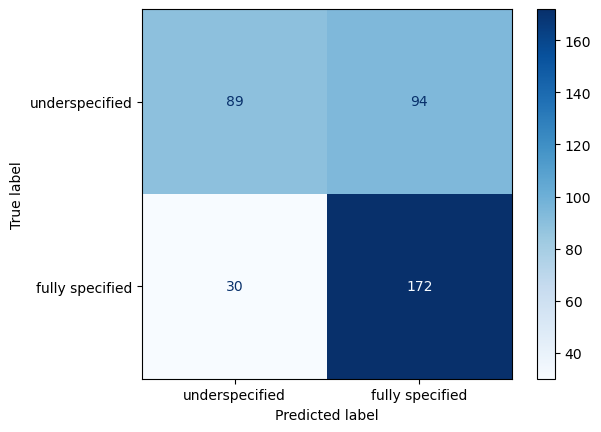

In [19]:
retrieve_results(test_df_1, "FS_UND_ICL_batch_1")

#### Batch 2

In [ ]:
test_prompts_2 = prepare_test_prompts(df_test_2, task_icl_no_theory, learning_df=df_in_context_learning, instruction_text=icl_intro_no_theory)
print(test_prompts_2[0])

In [21]:
test_df_2 = run_experiment(test_prompts_2, df_test_2)
test_df_2

100%|██████████| 97/97 [1:47:21<00:00, 66.40s/it]


,Unnamed: 0,request,gold_judgment,direct_source,thinking,model_response,model_pred
385,1053,Find the current most viewed livestream on Twi...,fully specified,IN3,"<think>\nOkay, let's tackle this query. The us...","{\n ""query"": ""Find the current most viewed li...",underspecified
386,233,List out the current members of the United Nat...,fully specified,IN3,"<think>\nOkay, let's see. The user is asking t...","{\n ""query"": ""List out the current members of...",fully specified
387,1389,Who played grandpa joe in charlie and the choc...,underspecified,AmbigQA,"<think>\nOkay, let's see. The user is asking, ...","{\n ""query"": ""Who played grandpa joe in charl...",fully specified
388,1252,When was the last time michigan was in the eli...,underspecified,AmbigQA,"<think>\nOkay, let's tackle this query. The us...","{\n ""query"": ""When was the last time michigan...",fully specified
389,1248,Classify the sentences below based on the sent...,fully specified,CLAMBER,"<think>\nOkay, let's tackle this user query st...","{\n ""query"": ""Classify the sentences below ba...",fully specified
...,...,...,...,...,...,...,...
765,1251,Who was the president of the United States in ...,fully specified,IN3,"<think>\nOkay, let's see. The user is asking, ...","{\n ""query"": ""Who was the president of the Un...",fully specified
766,1905,Who played draco malfoy in the harry potter mo...,fully specified,AmbigQA,"<think>\nOkay, let's see. The user is asking ""...","{\n ""query"": ""Who played draco malfoy in the ...",fully specified
767,1032,when did we become one of the leading manufact...,underspecified,CoCoNot,"<think>\nOkay, let's see. The user is asking w...","{\n ""query"": ""when did we become one of the l...",fully specified
768,1509,Who is jay park asia's got talent?,fully specified,AmbigQA,"<think>\nOkay, let's see. The user is asking ""...","{\n ""query"": ""Who is jay park asia's got tale...",fully specified


No error found, directly process the data.
                 precision    recall  f1-score   support

fully specified       0.65      0.89      0.75       208
 underspecified       0.77      0.44      0.56       177

       accuracy                           0.68       385
      macro avg       0.71      0.66      0.65       385
   weighted avg       0.70      0.68      0.66       385



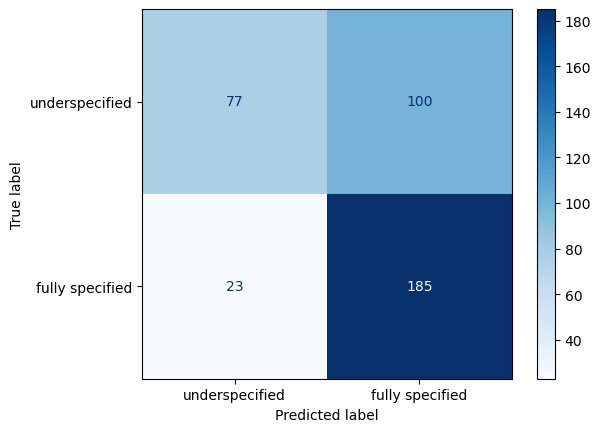

In [22]:
retrieve_results(test_df_2, "FS_UND_ICL_batch_2")

#### Batch 3

In [ ]:
test_prompts_3 = prepare_test_prompts(df_test_3, task_icl_no_theory, learning_df=df_in_context_learning, instruction_text=icl_intro_no_theory)
print(test_prompts_3[0])

In [24]:
test_df_3 = run_experiment(test_prompts_3, df_test_3)
test_df_3

100%|██████████| 97/97 [1:53:02<00:00, 69.93s/it]  


,Unnamed: 0,request,gold_judgment,direct_source,thinking,model_response,model_pred
770,584,Who has a baby in pitch perfect 3?,underspecified,CLAMBER,"<think>\nOkay, let's tackle this query: ""Who h...","{\n ""query"": ""Who has a baby in pitch perfect...",fully specified
771,419,I'm interested in amateur astronomy. Can you p...,fully specified,IN3,"<think>\nOkay, let me tackle this query. The u...","{\n ""query"": ""I'm interested in amateur astro...",underspecified
772,263,I need to declutter my closet. What's a good m...,underspecified,IN3,"<think>\nOkay, let's tackle this query. The us...","{\n ""query"": ""I need to declutter my closet. ...",underspecified
773,871,Who took hattrick in both innings in test?,fully specified,CLAMBER,"<think>\nOkay, let's tackle this query: ""Who t...","{\n ""query"": ""Who took hattrick in both innin...",underspecified
774,2353,What are some common symptoms of someone who i...,underspecified,CLAMBER,"<think>\nOkay, let's see. The user is asking, ...","{\n ""query"": ""What are some common symptoms o...",underspecified
...,...,...,...,...,...,...,...
1150,362,Who did the land ordinance of 1785 benefit?,underspecified,CLAMBER,"<think>\nOkay, let's see. The user is asking, ...","{\n ""query"": ""Who did the land ordinance of 1...",fully specified
1151,93,Is Bengalia depressa multicellular?,underspecified,CLAMBER,"<think>\nOkay, let's tackle this query. The us...","{\n ""query"": ""Is Bengalia depressa multicellu...",fully specified
1152,256,Does the developmental mode of Canthon hartman...,fully specified,CLAMBER,"<think>\nOkay, let's tackle this query: ""Does ...","{\n ""query"": ""Does the developmental mode of ...",fully specified
1153,999,Who won season 2 of america's got talent?,fully specified,CLAMBER,"<think>\nOkay, let's see. The user is asking ""...","{\n ""query"": ""Who won season 2 of america's g...",fully specified


No error found, directly process the data.
                 precision    recall  f1-score   support

fully specified       0.59      0.85      0.70       188
 underspecified       0.75      0.44      0.56       197

       accuracy                           0.64       385
      macro avg       0.67      0.64      0.63       385
   weighted avg       0.67      0.64      0.62       385



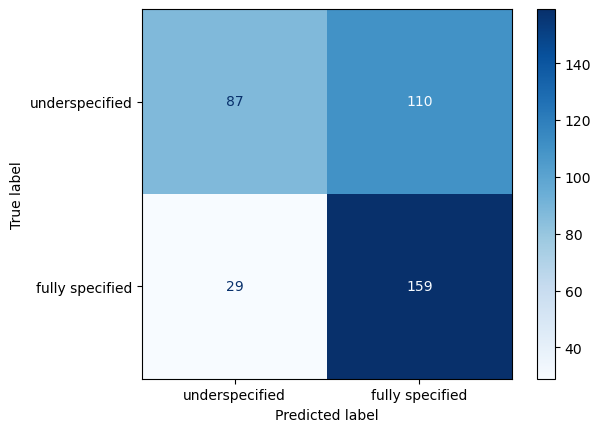

In [25]:
retrieve_results(test_df_3, "FS_UND_ICL_batch_3")

#### Combine

No error found, directly process the data.
                 precision    recall  f1-score   support

fully specified       0.63      0.86      0.73       598
 underspecified       0.76      0.45      0.57       557

       accuracy                           0.67      1155
      macro avg       0.69      0.66      0.65      1155
   weighted avg       0.69      0.67      0.65      1155



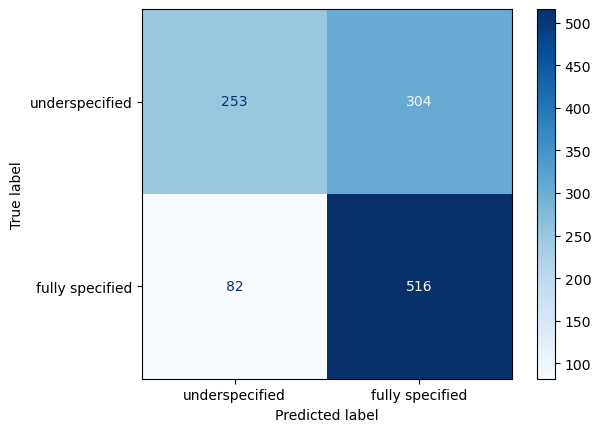

In [26]:
df_all = pd.concat([test_df_1, test_df_2, test_df_3])
retrieve_results(df_all, "FS_UND_ICL_all")

                 precision    recall  f1-score   support

fully specified       0.66      0.84      0.74       431
 underspecified       0.78      0.56      0.65       424

       accuracy                           0.70       855
      macro avg       0.72      0.70      0.70       855
   weighted avg       0.72      0.70      0.70       855



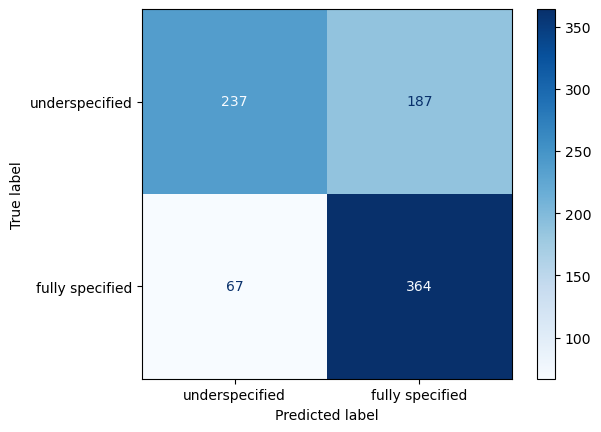

In [5]:
obtain_results_without("FS_UND_ICL_all.csv", "AmbigQA")

## Qwen3-4B NL MINI

In [9]:
task_categories = """
Analyze the following input user query:

{"query": "TARGET"}

Please provide your analysis in the following JSON format:

{"query": "TARGET", "reasoning": "[YOUR_DETAILED_REASONING]", "category": "[CATEGORY]", "judgment": "[fully specified/underspecified]"}

"category": select one or more labels (comma-separated) from 'Undetermined perspective or granularity', 'Missing necessary components', 'Undetermined lexicons or references', 'Undetermined standard or preference' if any undetermined factors exist. If the query is completely clear, output 'fully specified'.
"judgment": 'underspecified' if any undetermined factors exist in the query, 'fully specified' if the query is completely clear.

"""

### TRIAL TEST

In [21]:
trial_prompts = prepare_test_prompts(df_few_shots, task_categories)
print(trial_prompts[0])

Start preparing prompts...
# Testing data points: 12
Generation complete: 12 prompts
Average prompt length: 823 bytes (~205 tokens)

Analyze the following input user query:

{"query": "When did the nuclear accident happen?"}

Please provide your analysis in the following JSON format:

{"query": "When did the nuclear accident happen?_QUESTION", "reasoning": "[YOUR_DETAILED_REASONING]", "category": "[CATEGORY]", "judgment": "[fully specified/underspecified]"}

"category": select one or more labels (comma-separated) from 'Undetermined perspective or granularity', 'Missing necessary components', 'Undetermined lexicons or references', 'Undetermined standard or preference' if any undetermined factors exist. If the query is completely clear, output 'fully specified'.
"judgment": 'underspecified' if any undetermined factors exist in the query, 'fully specified' if the query is completely clear.




In [ ]:
trial_df = run_experiment(trial_prompts, df_few_shots)
trial_df

In [ ]:
retrieve_results(trial_df, "0622trial_FS_UND_categories")

### TEST_1155

In [10]:
test_prompts = prepare_test_prompts(df_test_1155, task_categories)
print(test_prompts[0])

Start preparing prompts...
# Testing data points: 1155
Generation complete: 1155 prompts
Average prompt length: 806 bytes (~201 tokens)

Analyze the following input user query:

{"query": "The idea that the united states was destined to extend westward across the continent?"}

Please provide your analysis in the following JSON format:

{"query": "The idea that the united states was destined to extend westward across the continent?", "reasoning": "[YOUR_DETAILED_REASONING]", "category": "[CATEGORY]", "judgment": "[fully specified/underspecified]"}

"category": select one or more labels (comma-separated) from 'Undetermined perspective or granularity', 'Missing necessary components', 'Undetermined lexicons or references', 'Undetermined standard or preference' if any undetermined factors exist. If the query is completely clear, output 'fully specified'.
"judgment": 'underspecified' if any undetermined factors exist in the query, 'fully specified' if the query is completely clear.




In [11]:
test_df = run_experiment(test_prompts, df_test_1155)
test_df

100%|██████████| 289/289 [2:17:50<00:00, 28.62s/it]  


,Unnamed: 0,request,gold_judgment,direct_source,thinking,model_response,model_pred
0,1787,The idea that the united states was destined t...,fully specified,AmbigQA,"<think>\nOkay, let's take a look at this query...","{\n ""query"": ""The idea that the united states...",underspecified
1,161,How many times french won the world cup?,fully specified,AmbigQA,"<think>\nOkay, let's tackle this query: ""How m...","{\n ""query"": ""How many times french won the w...",fully specified
2,1383,When was pink floyd's dark side of the moon re...,fully specified,AmbigQA,"<think>\nOkay, let me try to figure out if thi...","{\n ""query"": ""When was pink floyd's dark side...",fully specified
3,1111,When did leonardo da vinci finish painting the...,fully specified,AmbigQA,"<think>\nOkay, let's tackle this query: ""When ...","{\n ""query"": ""When did leonardo da vinci fini...",fully specified
4,1542,Who is the first speaker of national assembly ...,fully specified,AmbigQA,"<think>\nOkay, let's see. The user is asking f...","{\n ""query"": ""Who is the first speaker of nat...",underspecified
...,...,...,...,...,...,...,...
1150,335,Is Pensacola sylvestris a multicellular organi...,fully specified,CLAMBER,"<think>\nOkay, let's tackle this query. The us...","{\n ""query"": ""Is Pensacola sylvestris a multi...",underspecified
1151,337,What's the leaf mass per area of Larrea divari...,fully specified,CLAMBER,"<think>\nOkay, let me try to figure out if thi...","{\n ""query"": ""What's the leaf mass per area o...",underspecified
1152,364,When did Patsyella make its last appearance in...,fully specified,CLAMBER,"<think>\nOkay, let's tackle this query. The us...","{\n ""query"": ""When did Patsyella make its las...",fully specified
1153,276,What's the body mass of Salamandra salamandra?,fully specified,CLAMBER,"<think>\nOkay, let me try to figure this out. ...","{\n ""query"": ""What's the body mass of Salaman...",fully specified


No error found, directly process the data.
                 precision    recall  f1-score   support

fully specified       0.69      0.49      0.57       598
 underspecified       0.58      0.76      0.66       557

       accuracy                           0.62      1155
      macro avg       0.64      0.63      0.62      1155
   weighted avg       0.64      0.62      0.61      1155



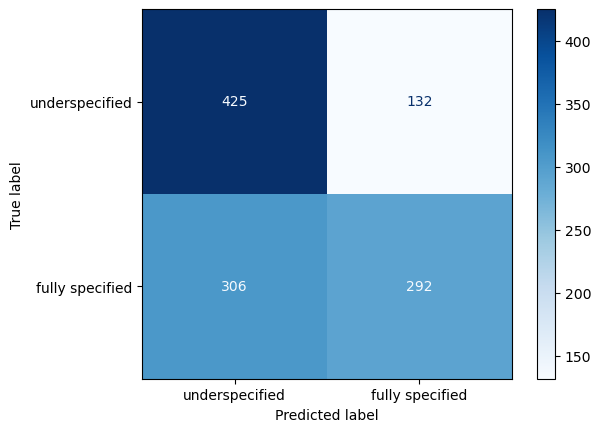

In [12]:
retrieve_results(test_df, "FS_UND_categories")

                 precision    recall  f1-score   support

fully specified       0.74      0.45      0.56       431
 underspecified       0.60      0.84      0.70       424

       accuracy                           0.64       855
      macro avg       0.67      0.64      0.63       855
   weighted avg       0.67      0.64      0.63       855



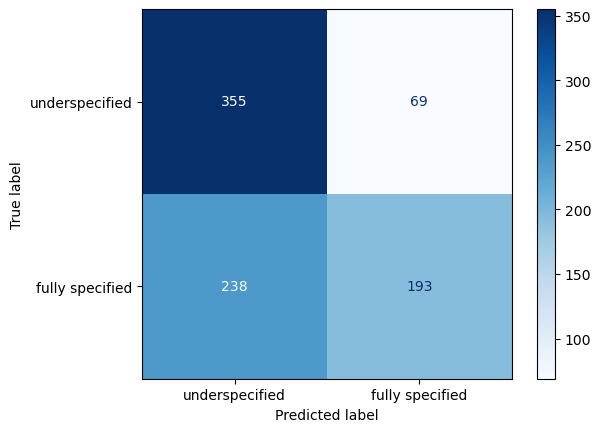

In [4]:
obtain_results_without("FS_UND_categories.csv", "AmbigQA")

## Qwen3-4B NL LIGHT

In [12]:
icl_intro = """
Here are examples of how to analyze user queries:

"""

task_icl = """

Now analyze the following input user query:

{"query": "TARGET", "reasoning": "[YOUR_DETAILED_REASONING]", "category": "[CATEGORY]", "judgment": "[fully specified/underspecified]"}

"category": select one or more labels (comma-separated) from 'Undetermined perspective or granularity', 'Missing necessary components', 'Undetermined lexicons or references', 'Undetermined standard or preference' if any undetermined factors exist. If the query is completely clear, output 'fully specified'.
"judgment": 'underspecified' if any undetermined factors exist in the query, 'fully specified' if the query is completely clear.
"""

### TRIAL TEST

In [ ]:
trial_prompts = prepare_test_prompts(df_few_shots, task_icl, learning_df=df_in_context_learning, instruction_text=icl_intro, theory=True)
print(trial_prompts[0])

In [ ]:
trial_df = run_experiment(trial_prompts, df_few_shots)
trial_df

In [ ]:
retrieve_results(trial_df, "0622trial_FS_UND_full_theory")

### TEST_1155

In [10]:
df_test_shuffled = df_test_1155.sample(frac=1, random_state=42).reset_index(drop=True)
dfs = np.array_split(df_test_shuffled, 5)
df_test_1 = dfs[0]
df_test_2 = dfs[1]
df_test_3 = dfs[2]
df_test_4 = dfs[3]
df_test_5 = dfs[4]

#### Batch 1

In [ ]:
test_prompts_1 = prepare_test_prompts(df_test_1, task_icl, learning_df=df_in_context_learning, instruction_text=icl_intro, theory=True)
print(test_prompts_1[0])

In [12]:
test_df_1 = run_experiment(test_prompts_1, df_test_1)
test_df_1

100%|██████████| 58/58 [2:17:12<00:00, 141.93s/it]  


,Unnamed: 0,request,gold_judgment,direct_source,thinking,model_response,model_pred
0,785,Who started the white out in college football?,underspecified,CLAMBER,"<think>\nOkay, let's tackle this query: ""Who s...","{\n ""query"": ""Who started the white out in co...",underspecified
1,365,What is the name of the tower big ben is in?,underspecified,AmbigQA,"<think>\nOkay, let's tackle this query: ""What ...","{\n ""query"": ""What is the name of the tower B...",fully specified
2,991,Who played ashley banks on fresh prince of bel...,fully specified,AmbigQA,"<think>\nOkay, let's tackle this query: ""Who p...","{\n ""query"": ""Who played ashley banks on fres...",fully specified
3,133,What was the number one song on october 2 1975?,underspecified,AmbigQA,"<think>\nOkay, let's tackle this query: ""What ...","{\n ""query"": ""What was the number one song on...",underspecified
4,1333,Tell me whether the following animals are part...,fully specified,CLAMBER,"<think>\nOkay, let's tackle this query analysi...","{\n ""query"": ""Tell me whether the following a...",fully specified
...,...,...,...,...,...,...,...
226,284,Does the skeleton of Ironus ignavus have soft ...,fully specified,CLAMBER,"<think>\nOkay, let's tackle this query analysi...","{\n ""query"": ""Does the skeleton of Ironus ign...",fully specified
227,1924,Melissa told Jennifer that the father-in-law s...,fully specified,CLAMBER,"<think>\nOkay, let's tackle this query analysi...","{\n ""query"": ""Melissa told Jennifer that the ...",fully specified
228,1097,Find information about the latest phishing scams.,underspecified,IN3,"<think>\nOkay, let's tackle this analysis. The...","{\n ""query"": ""Find information about the late...",underspecified
229,300,I want to secure my online accounts. What are ...,fully specified,IN3,"<think>\nOkay, let's tackle this analysis. The...","{\n ""query"": ""I want to secure my online acco...",underspecified


No error found, directly process the data.
                 precision    recall  f1-score   support

fully specified       0.68      0.73      0.70       120
 underspecified       0.68      0.62      0.65       111

       accuracy                           0.68       231
      macro avg       0.68      0.68      0.68       231
   weighted avg       0.68      0.68      0.68       231



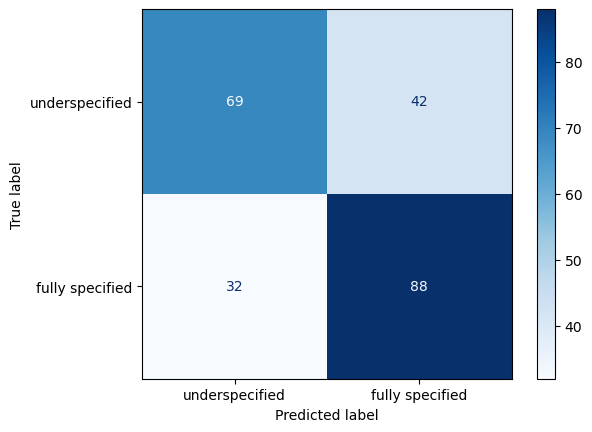

In [13]:
retrieve_results(test_df_1, "FS_UND_fulltheory_batch_1")

#### Batch 2

In [14]:
test_prompts_2 = prepare_test_prompts(df_test_2, task_icl, learning_df=df_in_context_learning, instruction_text=icl_intro, theory=True)
print(test_prompts_2[0])

Start preparing prompts...
# learning samples: 150
# Testing data points: 231
Generation complete: 231 prompts
Average prompt length: 72,270 bytes (~18,067 tokens)

Here are examples of how to analyze user queries:

{"query": "When was the first world war broke out?", "reasoning": "The phrase “broke out” can be interpreted from multiple perspectives or granularities. It can be interpreted from the perspective of the political trigger event, which is the assassination of Archduke Franz Ferdinand, or from the perspective of the formal military actions and declarations of war between major powers. The question remains underspecified before a certain perspective is chosen.", "category": "Undetermined perspective or granularity", "judgment": "underspecified"}

{"query": "Who sings the song i will try to fix you?", "reasoning": "The question allows multiple granularities: it could be answered on the granularity of the band as a whole or specifically to the lead singer, Chris Martin. Without 

In [15]:
test_df_2 = run_experiment(test_prompts_2, df_test_2)
test_df_2

100%|██████████| 58/58 [2:18:17<00:00, 143.07s/it]  


,Unnamed: 0,request,gold_judgment,direct_source,thinking,model_response,model_pred
231,643,Who is the leader of ruling party in rajya sabha?,underspecified,CLAMBER,"<think>\nOkay, let's tackle this query: ""Who i...","{\n ""query"": ""Who is the leader of ruling par...",underspecified
232,1873,What county is jersey city nj located in?,fully specified,AmbigQA,"<think>\nOkay, let's tackle this query: ""What ...","{\n ""query"": ""What county is jersey city nj l...",fully specified
233,814,Explain the basics of data analysis using pand...,fully specified,IN3,"<think>\nOkay, let's tackle this query. The us...","{\n ""query"": ""Explain the basics of data anal...",fully specified
234,739,Make a probability distribution of rolling two...,fully specified,IN3,"<think>\nOkay, let's tackle this query analysi...","{\n ""query"": ""Make a probability distribution...",fully specified
235,1524,Classify the below based on whether they are t...,fully specified,CLAMBER,"<think>\nOkay, let's tackle this query step by...","{\n ""query"": ""Classify the below based on whe...",fully specified
...,...,...,...,...,...,...,...
457,848,Find the inverse and determinant for a matrix.,underspecified,IN3,"<think>\nOkay, let's tackle this query analysi...","{\n ""query"": ""Find the inverse and determinan...",fully specified
458,495,Provide an overview of the Renaissance period ...,fully specified,IN3,"<think>\nOkay, let's tackle this analysis. The...","{\n ""query"": ""Provide an overview of the Rena...",fully specified
459,1004,When was the last world cup that brazil won?,underspecified,AmbigQA,"<think>\nOkay, let's tackle this query analysi...","{\n ""query"": ""When was the last world cup tha...",fully specified
460,855,Who plays harry in the amazing spider man 2?,fully specified,CLAMBER,"<think>\nOkay, let's see. The user is asking, ...","{\n ""query"": ""Who plays harry in the amazing ...",fully specified


No error found, directly process the data.
                 precision    recall  f1-score   support

fully specified       0.66      0.70      0.68       121
 underspecified       0.65      0.60      0.62       110

       accuracy                           0.65       231
      macro avg       0.65      0.65      0.65       231
   weighted avg       0.65      0.65      0.65       231



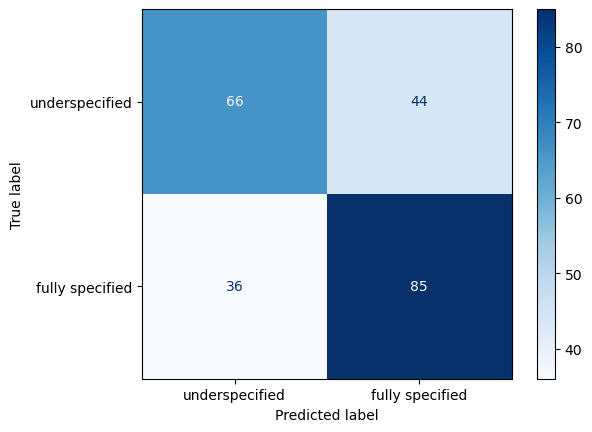

In [16]:
retrieve_results(test_df_2, "FS_UND_fulltheory_batch_2")

#### Batch 3

In [13]:
test_prompts_3 = prepare_test_prompts(df_test_3, task_icl, learning_df=df_in_context_learning, instruction_text=icl_intro, theory=True)
print(test_prompts_3[0])

Start preparing prompts...
# learning samples: 150
# Testing data points: 231
Generation complete: 231 prompts
Average prompt length: 72,269 bytes (~18,067 tokens)

Here are examples of how to analyze user queries:

{"query": "When was the first world war broke out?", "reasoning": "The phrase “broke out” can be interpreted from multiple perspectives or granularities. It can be interpreted from the perspective of the political trigger event, which is the assassination of Archduke Franz Ferdinand, or from the perspective of the formal military actions and declarations of war between major powers. The question remains underspecified before a certain perspective is chosen.", "category": "Undetermined perspective or granularity", "judgment": "underspecified"}

{"query": "Who sings the song i will try to fix you?", "reasoning": "The question allows multiple granularities: it could be answered on the granularity of the band as a whole or specifically to the lead singer, Chris Martin. Without 

In [14]:
test_df_3 = run_experiment(test_prompts_3, df_test_3)
test_df_3

100%|██████████| 58/58 [2:18:51<00:00, 143.65s/it]  


,Unnamed: 0,request,gold_judgment,direct_source,thinking,model_response,model_pred
462,1011,How many base pairs in diploid human genome?,fully specified,AmbigQA,"<think>\nOkay, let's tackle this query: ""How m...","{\n ""query"": ""How many base pairs in diploid ...",fully specified
463,187,I often feel stressed. Can you find me some ev...,fully specified,IN3,"<think>\nOkay, let's tackle this analysis. The...","{\n ""query"": ""I often feel stressed. Can you ...",underspecified
464,610,how do you win a ring,underspecified,CoCoNot,"<think>\nOkay, let's tackle this query: ""how d...","{\n ""query"": ""how do you win a ring"",\n ""rea...",underspecified
465,198,When did the capital of virginia moved from wi...,underspecified,CLAMBER,"<think>\nOkay, let's tackle this query analysi...","{\n ""query"": ""When did the capital of virgini...",fully specified
466,1115,Who plays simon's dad in the inbetweeners?,fully specified,CLAMBER,"<think>\nOkay, let's tackle this query analysi...","{\n ""query"": ""Who plays simon's dad in the in...",fully specified
...,...,...,...,...,...,...,...
688,1220,How many starbucks are there around the world?,underspecified,AmbigQA,"<think>\nOkay, let's tackle this query: ""How m...","{\n ""query"": ""How many starbucks are there ar...",fully specified
689,2301,In which studio recording was the song Wah-Wah...,fully specified,CLAMBER,"<think>\nOkay, let's tackle this query analysi...","{\n ""query"": ""In which studio recording was t...",underspecified
690,644,What year did the ipod touch 4 come out?,fully specified,AmbigQA,"<think>\nOkay, let's tackle this query: ""What ...","{\n ""query"": ""What year did the ipod touch 4 ...",fully specified
691,50,who was the last person executed in the state ...,fully specified,CoCoNot,"<think>\nOkay, let's tackle this query: ""who w...","{\n ""query"": ""who was the last person execute...",fully specified


No error found, directly process the data.
                 precision    recall  f1-score   support

fully specified       0.68      0.77      0.72       128
 underspecified       0.65      0.54      0.59       103

       accuracy                           0.67       231
      macro avg       0.66      0.65      0.66       231
   weighted avg       0.66      0.67      0.66       231



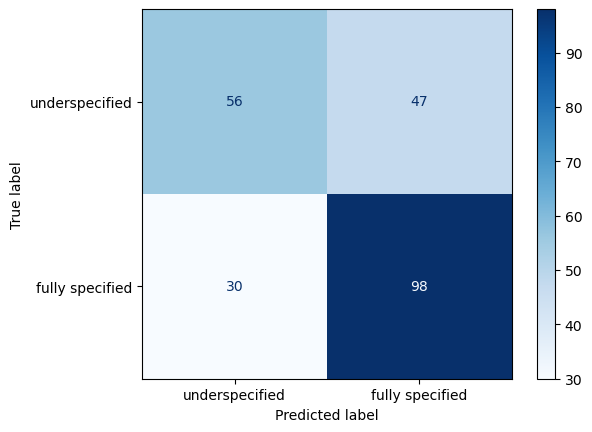

In [15]:
retrieve_results(test_df_3, "FS_UND_fulltheory_batch_3")

#### Batch 4

In [16]:
test_prompts_4 = prepare_test_prompts(df_test_4, task_icl, learning_df=df_in_context_learning, instruction_text=icl_intro, theory=True)
print(test_prompts_4[0])

Start preparing prompts...
# learning samples: 150
# Testing data points: 231
Generation complete: 231 prompts
Average prompt length: 72,271 bytes (~18,067 tokens)

Here are examples of how to analyze user queries:

{"query": "When was the first world war broke out?", "reasoning": "The phrase “broke out” can be interpreted from multiple perspectives or granularities. It can be interpreted from the perspective of the political trigger event, which is the assassination of Archduke Franz Ferdinand, or from the perspective of the formal military actions and declarations of war between major powers. The question remains underspecified before a certain perspective is chosen.", "category": "Undetermined perspective or granularity", "judgment": "underspecified"}

{"query": "Who sings the song i will try to fix you?", "reasoning": "The question allows multiple granularities: it could be answered on the granularity of the band as a whole or specifically to the lead singer, Chris Martin. Without 

In [17]:
test_df_4 = run_experiment(test_prompts_4, df_test_4)
test_df_4

100%|██████████| 58/58 [2:29:06<00:00, 154.25s/it]  


,Unnamed: 0,request,gold_judgment,direct_source,thinking,model_response,model_pred
693,2365,What does it mean to be observant?,underspecified,CLAMBER,"<think>\nOkay, let's tackle this analysis. The...","{\n ""query"": ""What does it mean to be observa...",underspecified
694,796,When was america taken off the gold standard?,underspecified,AmbigQA,"<think>\nOkay, let's tackle this query: ""When ...","{\n ""query"": ""When was america taken off the ...",underspecified
695,1658,Where was the show 13 reasons why filmed?,fully specified,AmbigQA,"<think>\nOkay, let's tackle this query analysi...","{\n ""query"": ""Where was the show 13 Reasons W...",fully specified
696,787,Locate the longest river in South America.,fully specified,IN3,"<think>\nOkay, let's tackle this query: ""Locat...","{\n ""query"": ""Locate the longest river in Sou...",fully specified
697,32,when was the treaty of 1763 signed in paris,fully specified,CoCoNot,"<think>\nOkay, let's tackle this query analysi...","{\n ""query"": ""when was the treaty of 1763 sig...",fully specified
...,...,...,...,...,...,...,...
919,65,Does Crop s minthe have larval development as ...,underspecified,CLAMBER,"<think>\nOkay, let's tackle this query step by...","{\n ""query"": ""Does Crop s minthe have larval ...",underspecified
920,83,Provide a list of materials needed and instruc...,underspecified,IN3,"<think>\nOkay, let's tackle this analysis step...","{\n ""query"": ""Provide a list of materials nee...",fully specified
921,761,who is the first female engineer,underspecified,CoCoNot,"<think>\nOkay, let's tackle this query: ""who i...","{\n ""query"": ""who is the first female enginee...",underspecified
922,258,I want to learn Python. Provide me with a road...,underspecified,IN3,"<think>\nOkay, let's tackle this analysis. The...","{\n ""query"": ""I want to learn Python. Provide...",fully specified


No error found, directly process the data.
                 precision    recall  f1-score   support

fully specified       0.68      0.79      0.73       115
 underspecified       0.75      0.63      0.69       116

       accuracy                           0.71       231
      macro avg       0.72      0.71      0.71       231
   weighted avg       0.72      0.71      0.71       231



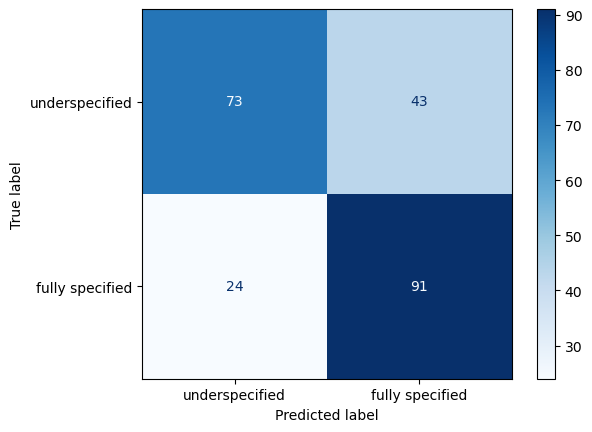

In [18]:
retrieve_results(test_df_4, "FS_UND_fulltheory_batch_4")

#### Batch 5

In [19]:
test_prompts_5 = prepare_test_prompts(df_test_5, task_icl, learning_df=df_in_context_learning, instruction_text=icl_intro, theory=True)
print(test_prompts_5[0])

Start preparing prompts...
# learning samples: 150
# Testing data points: 231
Generation complete: 231 prompts
Average prompt length: 72,266 bytes (~18,066 tokens)

Here are examples of how to analyze user queries:

{"query": "When was the first world war broke out?", "reasoning": "The phrase “broke out” can be interpreted from multiple perspectives or granularities. It can be interpreted from the perspective of the political trigger event, which is the assassination of Archduke Franz Ferdinand, or from the perspective of the formal military actions and declarations of war between major powers. The question remains underspecified before a certain perspective is chosen.", "category": "Undetermined perspective or granularity", "judgment": "underspecified"}

{"query": "Who sings the song i will try to fix you?", "reasoning": "The question allows multiple granularities: it could be answered on the granularity of the band as a whole or specifically to the lead singer, Chris Martin. Without 

In [20]:
test_df_5 = run_experiment(test_prompts_5, df_test_5)
test_df_5

100%|██████████| 58/58 [2:26:00<00:00, 151.05s/it]  


,Unnamed: 0,request,gold_judgment,direct_source,thinking,model_response,model_pred
924,43,when was the last time we had a republican may...,fully specified,CoCoNot,"<think>\nOkay, let's tackle this query analysi...","{\n ""query"": ""when was the last time we had a...",fully specified
925,174,Identify if the following instance is passive-...,underspecified,CLAMBER,"<think>\nOkay, let's tackle this analysis. The...","{\n ""query"": ""Identify if the following insta...",underspecified
926,150,How many islands are included in the federated...,fully specified,AmbigQA,"<think>\nOkay, let's tackle this query analysi...","{\n ""query"": ""How many islands are included i...",fully specified
927,1819,When was the last time an astronaut went to th...,fully specified,AmbigQA,"<think>\nOkay, let's tackle this query: ""When ...","{\n ""query"": ""When was the last time an astro...",fully specified
928,665,Who sings the song if you want my love you got...,underspecified,CLAMBER,"<think>\nOkay, let's tackle this query analysi...","{\n ""query"": ""Who sings the song if you want ...",underspecified
...,...,...,...,...,...,...,...
1150,362,Who did the land ordinance of 1785 benefit?,underspecified,CLAMBER,"<think>\nOkay, let's tackle this query: ""Who d...","{\n ""query"": ""Who did the Land Ordinance of 1...",fully specified
1151,93,Is Bengalia depressa multicellular?,underspecified,CLAMBER,"<think>\nOkay, let's tackle this query analysi...","{\n ""query"": ""Is Bengalia depressa multicellu...",fully specified
1152,256,Does the developmental mode of Canthon hartman...,fully specified,CLAMBER,"<think>\nOkay, let's tackle this query analysi...","{\n ""query"": ""Does the developmental mode of ...",fully specified
1153,999,Who won season 2 of america's got talent?,fully specified,CLAMBER,"<think>\nOkay, let's tackle this query analysi...","{\n ""query"": ""Who won season 2 of america's g...",fully specified


No error found, directly process the data.
                 precision    recall  f1-score   support

fully specified       0.60      0.68      0.63       114
 underspecified       0.64      0.56      0.59       117

       accuracy                           0.61       231
      macro avg       0.62      0.62      0.61       231
   weighted avg       0.62      0.61      0.61       231



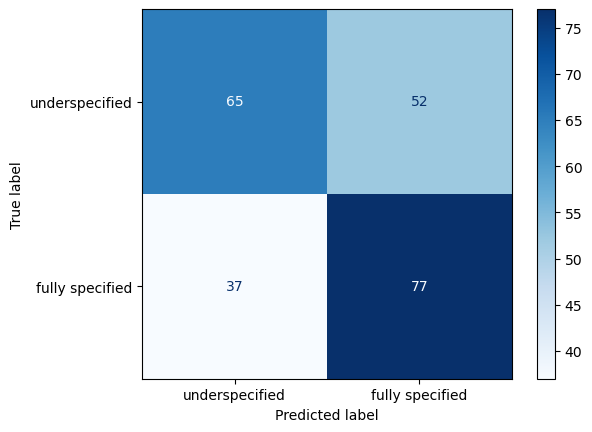

In [21]:
retrieve_results(test_df_5, "FS_UND_fulltheory_batch_5")

#### Combine

No error found, directly process the data.
                 precision    recall  f1-score   support

fully specified       0.66      0.73      0.69       598
 underspecified       0.67      0.59      0.63       557

       accuracy                           0.66      1155
      macro avg       0.67      0.66      0.66      1155
   weighted avg       0.67      0.66      0.66      1155



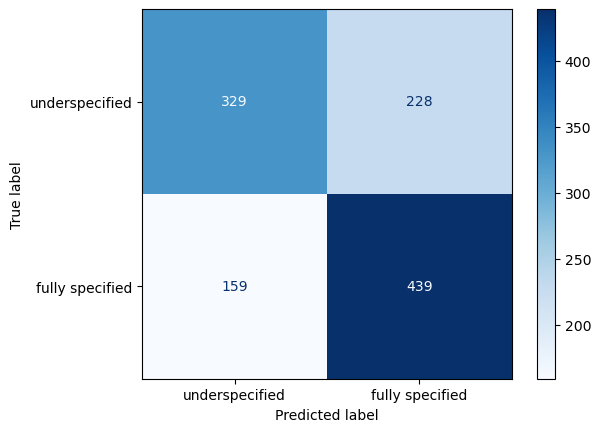

In [8]:
test_df_1 = pd.read_csv("FS_UND_fulltheory_batch_1.csv")
test_df_2 = pd.read_csv("FS_UND_fulltheory_batch_2.csv")
test_df_3 = pd.read_csv("FS_UND_fulltheory_batch_3.csv")
test_df_4 = pd.read_csv("FS_UND_fulltheory_batch_4.csv")
test_df_5 = pd.read_csv("FS_UND_fulltheory_batch_5.csv")

df_all = pd.concat([test_df_1, test_df_2, test_df_3, test_df_4, test_df_5])
retrieve_results(df_all, "FS_UND_fulltheory_all")

                 precision    recall  f1-score   support

fully specified       0.70      0.72      0.71       431
 underspecified       0.71      0.68      0.69       424

       accuracy                           0.70       855
      macro avg       0.70      0.70      0.70       855
   weighted avg       0.70      0.70      0.70       855



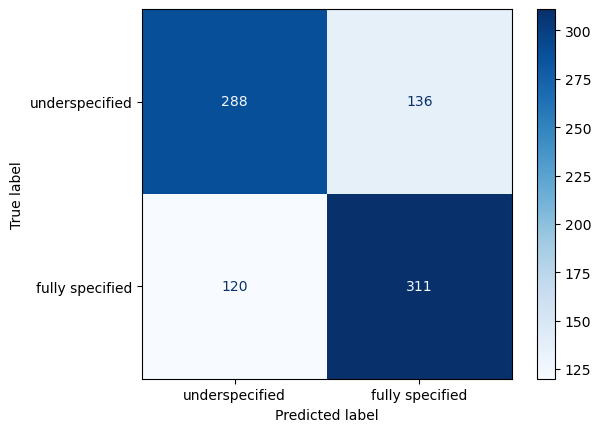

In [3]:
obtain_results_without("FS_UND_fulltheory_all.csv", "AmbigQA")